In [2]:
import sys
sys.path.append("../dev_scripts/")
import exp_tools
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
from fri import bounds,plot_dendrogram_and_intervals
from fri import *
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Data creation


* We want two features which can be replace each other without being correlated.
* To show the difference to a correlated pair, we add two of those and some other irrelevant features.

In [86]:
def gen_quadrant_problem_2weak(n=5000, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
    rs = random_state
    X = rs.rand(n, 2)
    class1 = 2 * rs.rand(n) - 1
    class2 = 2 * rs.rand(n) - 1
    
    X2, y2 = genClassificationData(n_samples=n, n_features=5, n_strel=0, n_redundant=2,
                                   n_repeated=0, flip_y=0, random_state=rs)
    # Stack the two constructed with another toy set
    X = np.hstack([X, X2])
    X = StandardScaler().fit_transform(X)
    y = X[:, 0] + X[:, 1] + X[:, 2] > 0

    return X, y

In [87]:
n = 1000
rs = np.random.RandomState(125)
X,y = gen_quadrant_problem_2weak(n=n,random_state=rs)

Generating dataset with d=5,n=1000,strongly=0,weakly=2, partition of weakly=None


### Plot of first two features

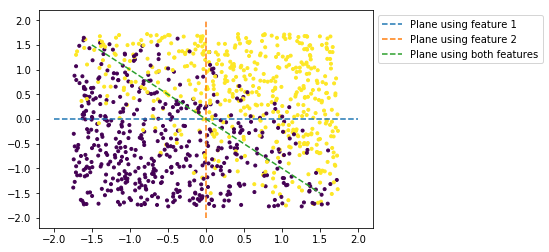

In [88]:
plt.scatter(*X[:,0:2].T,c=y,marker=".")
plt.plot((-2,2),(0,0),"--")
plt.plot((0,0),(-2,2),"--")
plt.plot((-1.5,1.5),(1.5,-1.5),"--")
plt.legend(["Plane using feature 1", "Plane using feature 2", "Plane using both features"],loc="best",bbox_to_anchor=(1,1))

# Normal model fit

In [103]:
f = FRIClassification(debug=True)
f.fit(X,y)

loss 1.93837278786e-07
L1 273.687767324
offset 0.330116021378049
C 100
score 1.0
coef:
[[ 81.96068917]
 [ 83.67542842]
 [ 40.55688645]
 [-40.55688569]
 [ -0.59241584]
 [ -0.97467071]
 [ -0.49008492]]


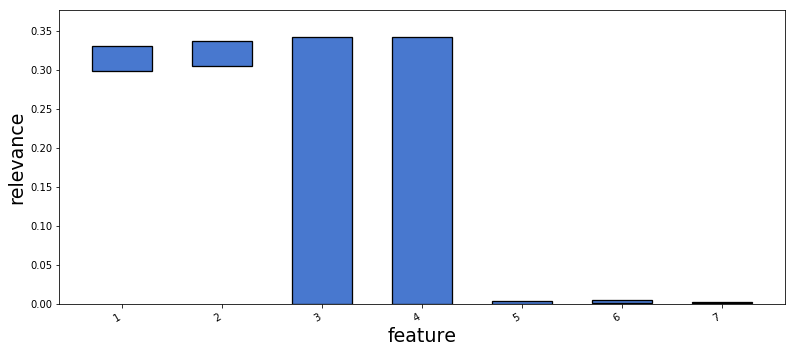

In [104]:
p = plotIntervals(f.interval_)

### Observation
both first two features strongly relevant, model uses both features

# Model fit with relaxed constraints

In [182]:
f = FRIClassification(debug=True,optimum_deviation=0.15,C=0.1)
f.fit(X,y)

loss 74.753603254
L1 8.89455057163
offset 0.038278947698104714
C 0.1
score 0.991000585099
coef:
[[  2.62592821e+00]
 [  2.56067073e+00]
 [  1.23839563e+00]
 [ -1.23839575e+00]
 [  5.48167667e-02]
 [  3.18502682e-12]
 [  1.61847119e-02]]


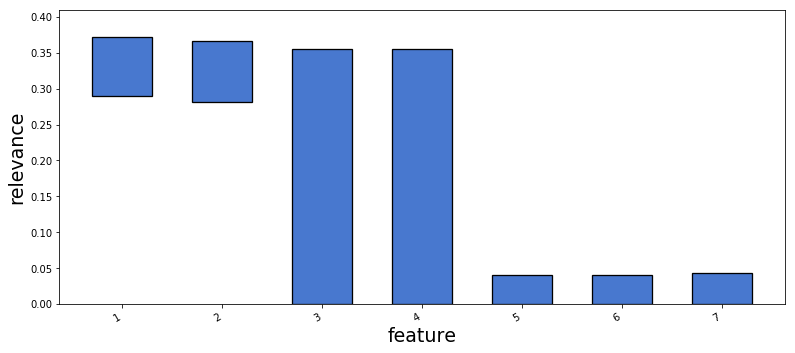

In [183]:
p = plotIntervals(f.interval_)

#### Observation 
First two features turned into weakly relevant, One of both can fulfill function in the model

# Question: How to find these pairings in a given dataset?

We use our relevance bounds to find the features which take over the role of other features.

* We constrain each feature separately to one of its relevance bounds and solve the relevance bounds for all others.
* We look at the difference between the unconstrained solution (seen above) and the constrained one for each of these separate optimizations.

In [225]:
for pr in range(0,90000):
    preset = np.empty(shape=(X.shape[1], 2))
    preset.fill(np.nan)
    preset[0] = pr/1000
    try:
        rangevector, _,_,_ = f._main_opt(X,y,f.optim_loss_,f.optim_L1_,rs,False,presetModel=preset)
    except:
        continue
    print(pr/1000)

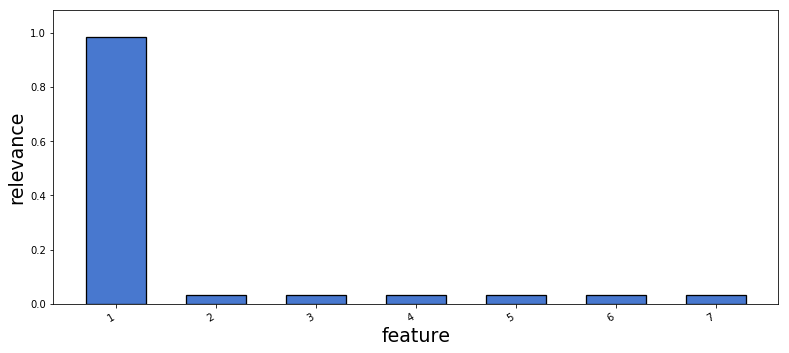

In [181]:
p = plotIntervals(rangevector)

In [10]:
clust, link, feat_points,dist_mat = f.community_detection2(X,y)


In [11]:
import scipy
dist_mat = scipy.spatial.distance.squareform(dist_mat)

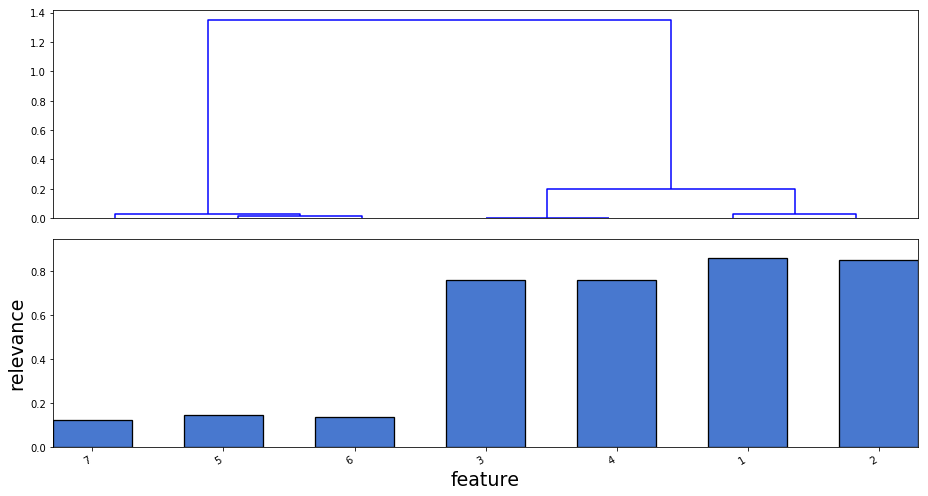

In [12]:
p = plot_dendrogram_and_intervals(f.interval_,link)

In [13]:
import pandas as pd
pd.DataFrame(X).corr()

,0,1,2,3,4,5,6
0,1.000000,0.041688,-0.013250,0.013250,0.068489,0.009713,-0.024199
1,0.041688,1.000000,0.009897,-0.009897,0.017740,0.001767,0.001497
2,-0.013250,0.009897,1.000000,-1.000000,-0.002976,0.050858,0.021815
3,0.013250,-0.009897,-1.000000,1.000000,0.002976,-0.050858,-0.021815
4,0.068489,0.017740,-0.002976,0.002976,1.000000,-0.010376,-0.000962
5,0.009713,0.001767,0.050858,-0.050858,-0.010376,1.000000,-0.047092
6,-0.024199,0.001497,0.021815,-0.021815,-0.000962,-0.047092,1.000000


In [14]:
import seaborn as sns

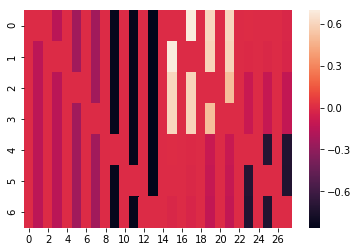

In [15]:
sns.heatmap(feat_points)

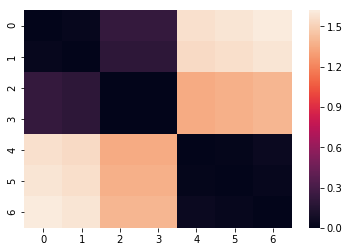

In [16]:
sns.heatmap(dist_mat)

# Correlation based grouping

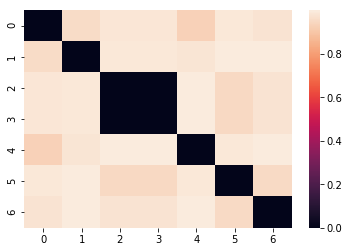

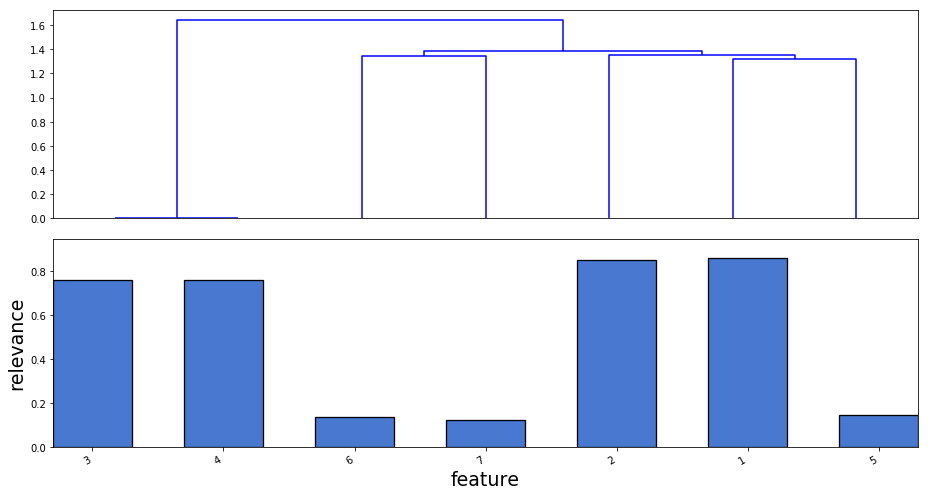

In [19]:
import pandas as pd
import seaborn as sns
corr_pd = pd.DataFrame(X).corr()

corr_pd = 1-corr_pd.abs()
corr_pd = corr_pd.values

sns.heatmap(corr_pd)

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
z = linkage(corr_pd,method="single")
threshold = 0.55*np.max(z[:, 2])
p = plot_dendrogram_and_intervals(f.interval_,z)